# TEXT SUMMARIZATION USING Gen AI Model

#### We are using tv_dialog dataset from hugging face, our approach involves leveraging the Flan T5 base LLM model to extract and process information, generating responses based on user prompts. We employ various scenarios to investigate the impact of input text on model output. Through prompt engineering techniques, we aim to guide the model towards specific tasks. The comparison of zero-shot, one-shot, and few-shot inferences allows us to initiate prompt engineering, showcasing its potential to improve the generative capabilities of Large Language Models.



# Set up Kernel and Required Dependencies

In [1]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

# Installing the Reinforcement Learning library directly from github.
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd

  Cloning https://github.com/lvwerra/trl.git (to revision 25fa1bd) to /tmp/pip-req-build-rg0mei49
  Running command git clone --filter=blob:none --quiet https://github.com/lvwerra/trl.git /tmp/pip-req-build-rg0mei49
  Running command git checkout -q 25fa1bd
  Resolved https://github.com/lvwerra/trl.git to commit 25fa1bd
  Preparing metadata (setup.py) ... done


In [2]:
!pip install py7zr

In [3]:
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
from peft import PeftModel, PeftConfig, LoraConfig, TaskType


# trl: Transformer Reinforcement Learning library
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler
# tqdm library makes the loops show a smart progress meter.
from tqdm import tqdm
tqdm.pandas()

## Load Dataset and LLM

In [4]:
model_name="google/flan-t5-base"
huggingface_dataset_name = "sedthh/tv_dialogue"

dataset_original = load_dataset(huggingface_dataset_name)

dataset_original

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['TEXT', 'METADATA', 'SOURCE'],
        num_rows: 2781
    })
})

## LAB 1---------





In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [6]:
dataset = dataset_original['train']
example_rows = 1

In [6]:
dash_line = '-'.join('' for x in range(100))
dataset
for i in range(example_rows):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(dataset['TEXT'][i])
    print(dash_line)
    print('METADATA:')
    print(dataset['METADATA'][i])
    print(dash_line)
    print()


---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE:
Doctor Who (23 Nov, 1963; First Doctor) - An Unearthly Child

(Coal Hill School corridor)
[GIRL] Night, Miss Wright.
[BARBARA] Wait in here, please, Susan. I won't be long.
[BOY] Goodnight, Miss Wright.

---------------------------------------

(Laboratory)
[IAN] Oh? Not gone yet?
[BARBARA] Obviously not.
[IAN] Right, ask a silly question.
[BARBARA] I'm sorry.
[IAN] That's all right. I'll forgive you this time.
[BARBARA] Oh, I had a terrible day. I don't know what to make of it.
[IAN] Oh, what's the trouble? Can I help?
[BARBARA] Oh, it's one of the girls, Susan Foreman.
[IAN] Susan Foreman? She your problem too?
[BARBARA] Yes.
[IAN] You don't know what to make of her?
[BARBARA] No.
[IAN] How old is she, Barbara?
[BARBARA] Fifteen.
[IAN] Fifteen. She lets her kno

In [8]:
for i in range(example_rows):
    dialogue = dataset['TEXT'][i]

    # Tokenize the input dialogue
    inputs = tokenizer(dialogue, return_tensors='pt', truncation=True, max_length=620)

    # Generate output
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_length=50,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Doctor Who (23 Nov, 1963; First Doctor) - An Unearthly Child

(Coal Hill School corridor)
[GIRL] Night, Miss Wright.
[BARBARA] Wait in here, please, Susan. I won't be long.
[BOY] Goodnight, Miss Wright.

---------------------------------------

(Laboratory)
[IAN] Oh? Not gone yet?
[BARBARA] Obviously not.
[IAN] Right, ask a silly question.
[BARBARA] I'm sorry.
[IAN] That's all right. I'll forgive you this time.
[BARBARA] Oh, I had a terrible day. I don't know what to make of it.
[IAN] Oh, what's the trouble? Can I help?
[BARBARA] Oh, it's one of the girls, Susan Foreman.
[IAN] Susan Foreman? She your problem too?
[BARBARA] Yes.
[IAN] You don't know what to make of her?
[BARBARA] No.
[IAN] How old is she, Barbara?
[BARBARA] Fifteen.
[IAN] Fifteen. She lets her knowl

## Extracting Summaries from Dialogues: Zero Prompt Engineering Approach





#### ZERO SHOT INEFERENCE -
##### The concept of zero-shot inference involves directing the model to perform a task without explicit training on that specific task. Instead of training the model(as in the original lab) on a specific summarization task, a set of predefined prompts is used to instruct the model on how to generate summaries for given dialogues.The prompts, such as describing main characters, identifying genres, or mentioning locations, serve as guiding instructions for the model. These prompts provide different perspectives or aspects related to the dialogue content. The model then generates summaries based on these instructions, allowing for a versatile approach to dialogue summarization without the need for task-specific training.

In [9]:
# Adding different questions with some reference of what type of data we are looking for or in some cases we are just giving the question only

prompts = [
    "Describe the main characters in this TV show.",
    "Identify the genre of this TV show. Like Classic or Comedy",
    "Identify the title of this TV show.",
    "Locations mentioned in the TV show? Like city names",
    "Describe the main settings and locations featured in this series."
]
count = 0
for i in range(example_rows):
    dialogue = dataset['TEXT'][i]
    summary = dataset['METADATA'][i]

    for prompt in prompts:
        full_prompt = f"""
            {prompt}

            {dialogue}

            Summary:
        """

        # Input constructed prompt instead of the dialogue.
        inputs = tokenizer(full_prompt, return_tensors='pt', truncation=True, max_length=512)
        output = tokenizer.decode(
            model.generate(
                inputs["input_ids"],
                max_new_tokens=50,
                num_beams=5,
                length_penalty=2.0,
                early_stopping=True
            )[0],
            skip_special_tokens=True
        )

        print(dash_line)
        count += 1
        print(f'Example {count} - Prompt: {prompt}')
        print(dash_line)
        print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')


---------------------------------------------------------------------------------------------------
Example 1 - Prompt: Describe the main characters in this TV show.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Susan Foreman

---------------------------------------------------------------------------------------------------
Example 2 - Prompt: Identify the genre of this TV show. Like Classic or Comedy
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Comedy

---------------------------------------------------------------------------------------------------
Example 3 - Prompt: Identify the title of this TV show.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Doctor Who

--------------------------------------------------------------------------

#### Question
##### Experiment with the prompt text and see how the inferences will be changed. Will the inferences change if you end the prompt with just empty string vs. Summary:

In [12]:
prompts = [
    "characters in ",
    "Describe the main "
]
count = 0
for i in range(example_rows):
    dialogue = dataset['TEXT'][i]
    summary = dataset['METADATA'][i]

    for prompt in prompts:
        full_prompt = f"""
            {prompt}

            {dialogue}
        """

        # Input constructed prompt instead of the dialogue.
        inputs = tokenizer(full_prompt, return_tensors='pt', truncation=True, max_length=512)
        output = tokenizer.decode(
            model.generate(
                inputs["input_ids"],
                max_new_tokens=50,
                num_beams=5,
                length_penalty=2.0,
                early_stopping=True
            )[0],
            skip_special_tokens=True
        )

        print(dash_line)
        count += 1
        print(f'Example {count} - Prompt: {prompt}')
        print(dash_line)
        print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')


---------------------------------------------------------------------------------------------------
Example 1 - Prompt: characters in 
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Susan Foreman's grandfather didn't like strangers.

---------------------------------------------------------------------------------------------------
Example 2 - Prompt: Describe the main 
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
---------------------------------------



##### Result-  It is still working the same way as it was doing earlier with empty ended string

## Extracting Summaries from Dialogues: One Shot Prompt Engineering Approach

In [13]:
def make_prompt(num_rows):
    prompt = ""
    for i in range(num_rows):
        dialogue = dataset['TEXT'][i]
        summary = dataset['METADATA'][i]

        # The stop sequence is important. Check if it's appropriate for your model.
        prompt += f"""
Dialogue:

{dialogue}

Title:

{summary}
"""

    # Use the last available index for dialogue and summary
    dialogue = dataset['TEXT'][num_rows]
    summary = dataset['METADATA'][num_rows]

    prompt += f"""
Dialogue:

{dialogue}

Identify the title of this TV show.
"""

    return prompt

num_rows = 1
one_shot_prompt = make_prompt(num_rows)
print(one_shot_prompt)

# Assuming 'METADATA' field contains the title information
summary = dataset['METADATA'][num_rows]

inputs = tokenizer(one_shot_prompt, return_tensors='pt', truncation=True, max_length=512)
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
        num_beams=5,
        length_penalty=2.0,
        early_stopping=True
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'Title:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}\n')



Dialogue:

Doctor Who (23 Nov, 1963; First Doctor) - An Unearthly Child

(Coal Hill School corridor)
[GIRL] Night, Miss Wright.
[BARBARA] Wait in here, please, Susan. I won't be long.
[BOY] Goodnight, Miss Wright.

---------------------------------------

(Laboratory)
[IAN] Oh? Not gone yet?
[BARBARA] Obviously not.
[IAN] Right, ask a silly question.
[BARBARA] I'm sorry.
[IAN] That's all right. I'll forgive you this time.
[BARBARA] Oh, I had a terrible day. I don't know what to make of it.
[IAN] Oh, what's the trouble? Can I help?
[BARBARA] Oh, it's one of the girls, Susan Foreman.
[IAN] Susan Foreman? She your problem too?
[BARBARA] Yes.
[IAN] You don't know what to make of her?
[BARBARA] No.
[IAN] How old is she, Barbara?
[BARBARA] Fifteen.
[IAN] Fifteen. She lets her knowledge out a bit at a time so as not toembarrass me. That's what I feel about her. She knows more science thanI'll ever know. She's a genius. Is that what she's doing with history?
[BARBARA] Something like that.
[IA

##### In the above reuslt the one shot is not able to identify the title of the show and giving random conversation only

In [14]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Example index for one-shot inference
example_index_one_shot = 1  # Adjust as needed

# Construct prompt for one-shot inference
one_shot_prompt = ""
dialogue_one_shot = dataset['TEXT'][example_index_one_shot]

one_shot_prompt += f"""


Summarize the TV show.

Dialogue:

{dialogue_one_shot}



"""

# Generate output for one-shot inference
inputs_one_shot = tokenizer(one_shot_prompt, return_tensors='pt', truncation=True, max_length=620)
output_one_shot = tokenizer.decode(
    model.generate(
        inputs_one_shot["input_ids"],
        max_length=50,
        num_beams=5,
        length_penalty=2.0,
        early_stopping=True
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print('One-Shot Inference:')
print(dash_line)
print(f'One-Shot Prompt:\n{one_shot_prompt}')
print(dash_line)
print(f'Model Generation - One-Shot:\n{output_one_shot}\n')


---------------------------------------------------------------------------------------------------
One-Shot Inference:
---------------------------------------------------------------------------------------------------
One-Shot Prompt:



Summarize the TV show.

Dialogue:

Doctor Who (21 Dec, 1963; First Doctor) - The Daleks

(Tardis)
[DOCTOR] Well, I suggest before we go outside andexplore, let us clean ourselves up.
[SUSAN] Oh, yes.
[DOCTOR] Now what does the radiation read, Susan?
[SUSAN] It's reading normal, Grandfather.

---------------------------------------

(Forest)
[BARBARA] There's been a forest fire. Everything'ssort of white and ashen.
[IAN] Funny mist.
[DOCTOR] The heat must have been indescribable. Look at this soil here.Look at it. It's all turn to sand and ashes. Extraordinary. How canshrubs or trees grow in soil like that, hmm?
[IAN] Something else that's strange. There's quite a breeze blowing.
[SUSAN] Well?
[IAN] Well, look at the branches and things.
[SUSAN] They 

## Extracting Summaries from Dialogues: Few Shot Prompt Engineering Approach

In [15]:
# Example indices for few-shot inference
example_indices_few_shot = [0, 1, 2]  # Adjust as needed

# Construct prompt for few-shot inference
few_shot_prompt = ""
for index in example_indices_few_shot:
    dialogue = dataset['TEXT'][index]


    few_shot_prompt += f"""

Who is the most common character of the TV show?
Dialogue:

{dialogue}

"""

# Generate output for few-shot inference
inputs_few_shot = tokenizer(few_shot_prompt, return_tensors='pt', truncation=True, max_length=620)
output_few_shot = tokenizer.decode(
   model.generate(
      inputs_few_shot["input_ids"],
      max_length=50,
      num_beams=4,
      length_penalty=2.0,
      early_stopping=True
    )[0],
    skip_special_tokens=True
   )
print(dash_line)
print('Few-Shot Inference:')
print(dash_line)
print(f'Few-Shot Prompt:\n{few_shot_prompt}')
print(dash_line)
print(f'Model Generation - Few-Shot:\n{output_few_shot}\n')

---------------------------------------------------------------------------------------------------
Few-Shot Inference:
---------------------------------------------------------------------------------------------------
Few-Shot Prompt:


Who is the most common character of the TV show?
Dialogue:

Doctor Who (23 Nov, 1963; First Doctor) - An Unearthly Child

(Coal Hill School corridor)
[GIRL] Night, Miss Wright.
[BARBARA] Wait in here, please, Susan. I won't be long.
[BOY] Goodnight, Miss Wright.

---------------------------------------

(Laboratory)
[IAN] Oh? Not gone yet?
[BARBARA] Obviously not.
[IAN] Right, ask a silly question.
[BARBARA] I'm sorry.
[IAN] That's all right. I'll forgive you this time.
[BARBARA] Oh, I had a terrible day. I don't know what to make of it.
[IAN] Oh, what's the trouble? Can I help?
[BARBARA] Oh, it's one of the girls, Susan Foreman.
[IAN] Susan Foreman? She your problem too?
[BARBARA] Yes.
[IAN] You don't know what to make of her?
[BARBARA] No.
[IAN] How

In [16]:
# Example indices for few-shot inference
example_indices_few_shot = [0, 1, 2]  # Adjust as needed

# Construct prompt for few-shot inference
few_shot_prompt = ""
for index in example_indices_few_shot:
    dialogue = dataset['TEXT'][index]


    few_shot_prompt += f"""

what is the first dialogue of the most common character in the TV show?

Dialogue:

{dialogue}



"""

    print(f"{count} {few_shot_prompt}")



# Generate output for few-shot inference
inputs_few_shot = tokenizer(few_shot_prompt, return_tensors='pt', truncation=True, max_length=620)
output_few_shot = tokenizer.decode(
   model.generate(
      inputs_few_shot["input_ids"],
      max_length=50,
      num_beams=4,
      length_penalty=2.0,
      early_stopping=True
    )[0],
    skip_special_tokens=True
   )
print(dash_line)
print('Few-Shot Inference:')
print(dash_line)
print(f'Few-Shot Prompt:\n{few_shot_prompt}')
print(dash_line)
print(f'Model Generation - Few-Shot:\n{output_few_shot}\n')

Streaming output truncated to the last 5000 lines.
[SUSAN] The Thals! They've come for food supplies.
[DOCTOR] They're walking into an ambush.

---------------------------------------

(Room)
[DALEK 2] Make no attempt to capture them. They are to be exterminated.You understand? Exterminated.
[DALEK 1] I understand.

---------------------------------------

(Level One)
[IAN] Oh, it's no good. This room must be soundproof. We must find a wayof getting down there.
[DOCTOR] Yes, but how, dear boy?
[BARBARA] Isn't this a door?
[IAN] Yes! Doctor, open it.
[DOCTOR] Well, yes.
[SUSAN] What's the matter with it?
[DOCTOR] They've magnetised it, too. Come on, let's try and force itopen.
[IAN] I can get my fingers in. Sorry. Yes, it's beginning to move.
[BARBARA] Ian, the lift's coming back!
[SUSAN] Oh, no.
[IAN] Doctor, keep working the door. (he tries the lift controls) It'sno good. Wait. Come over here and give me a hand. Quick, now. All pushtogether.
[DOCTOR] It's open. I've done it.
[SUSAN] G

In [23]:
# Setting the generation config parameters different to
generation_config = GenerationConfig(max_tokens=50, do_sample=True)

# Example indices for few-shot inference
example_indices_few_shot = [0, 1, 2]  # Adjust as needed

# Construct prompt for few-shot inference
few_shot_prompt = ""
for index in example_indices_few_shot:
    dialogue = dataset['TEXT'][index]


    few_shot_prompt += f"""

Summarize the text conversations between the  Doctor and Susan.

Dialogue:

{dialogue}



"""

    print(f"{count} {few_shot_prompt}")



# Generate output for few-shot inference
inputs_few_shot = tokenizer(few_shot_prompt, return_tensors='pt', truncation=True, max_length=620)
output_few_shot = tokenizer.decode(
   model.generate(
      inputs_few_shot["input_ids"],
      num_beams=4,
      generation_config=generation_config,
      length_penalty=2.0,
      early_stopping=True
    )[0],
    skip_special_tokens=True
   )
print(dash_line)
print('Few-Shot Inference:')
print(dash_line)
print(f'Few-Shot Prompt:\n{few_shot_prompt}')
print(dash_line)
print(f'Model Generation - Few-Shot:\n{output_few_shot}\n')

Streaming output truncated to the last 5000 lines.
[SUSAN] The Thals! They've come for food supplies.
[DOCTOR] They're walking into an ambush.

---------------------------------------

(Room)
[DALEK 2] Make no attempt to capture them. They are to be exterminated.You understand? Exterminated.
[DALEK 1] I understand.

---------------------------------------

(Level One)
[IAN] Oh, it's no good. This room must be soundproof. We must find a wayof getting down there.
[DOCTOR] Yes, but how, dear boy?
[BARBARA] Isn't this a door?
[IAN] Yes! Doctor, open it.
[DOCTOR] Well, yes.
[SUSAN] What's the matter with it?
[DOCTOR] They've magnetised it, too. Come on, let's try and force itopen.
[IAN] I can get my fingers in. Sorry. Yes, it's beginning to move.
[BARBARA] Ian, the lift's coming back!
[SUSAN] Oh, no.
[IAN] Doctor, keep working the door. (he tries the lift controls) It'sno good. Wait. Come over here and give me a hand. Quick, now. All pushtogether.
[DOCTOR] It's open. I've done it.
[SUSAN] G

In [24]:
# Setting the generation config parameters different to
generation_config = GenerationConfig(max_tokens=50, do_sample=True, temperature =0.5)

# Example indices for few-shot inference
example_indices_few_shot = [0, 1, 2]  # Adjust as needed

# Construct prompt for few-shot inference
few_shot_prompt = ""
for index in example_indices_few_shot:
    dialogue = dataset['TEXT'][index]


    few_shot_prompt += f"""

Summarize the text conversations between the  Doctor and Susan.

Dialogue:

{dialogue}



"""

    print(f"{count} {few_shot_prompt}")



# Generate output for few-shot inference
inputs_few_shot = tokenizer(few_shot_prompt, return_tensors='pt', truncation=True, max_length=620)
output_few_shot = tokenizer.decode(
   model.generate(
      inputs_few_shot["input_ids"],
      num_beams=4,
      generation_config=generation_config,
      length_penalty=2.0,
      early_stopping=True
    )[0],
    skip_special_tokens=True
   )
print(dash_line)
print('Few-Shot Inference:')
print(dash_line)
print(f'Few-Shot Prompt:\n{few_shot_prompt}')
print(dash_line)
print(f'Model Generation - Few-Shot:\n{output_few_shot}\n')

Streaming output truncated to the last 5000 lines.
[DALEK 1] You must leave now.
[IAN] I'm not well enough yet.
[DALEK 1] You must leave now.
[IAN] My legs are still
[DALEK 1] Which one of you is going?
[IAN] You must give me more time.
[SUSAN] Can't you see how weak he is?
[DALEK 1] There are others.
[BARBARA] Oh, Ian, I can't. The whole room's going round.
[SUSAN] Must I? Alone?
[BARBARA] You can't let her go alone. She's just a child. Plead withthem. Anything!
[IAN] Susan, you see how ill they both are. We can't afford to waituntil I can walk. An hour might make all the difference.
[SUSAN] I'm so afraid.
[IAN] Go on.
[SUSAN] Yes.
[IAN] Don't stop for anything. Straight there, straight back.
[DALEK 1] Are you ready?
[IAN] Yes, all right.
[SUSAN] I'm coming now.
[BARBARA] Ian, the others in the forest. He said they were mutations.
[IAN] But what else could I do?

---------------------------------------

(Control room)
[DALEK 2] The child has set out.
[DALEK 1] Her direction is being f

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


---------------------------------------------------------------------------------------------------
Few-Shot Inference:
---------------------------------------------------------------------------------------------------
Few-Shot Prompt:


Summarize the text conversations between the  Doctor and Susan.

Dialogue:

Doctor Who (23 Nov, 1963; First Doctor) - An Unearthly Child

(Coal Hill School corridor)
[GIRL] Night, Miss Wright.
[BARBARA] Wait in here, please, Susan. I won't be long.
[BOY] Goodnight, Miss Wright.

---------------------------------------

(Laboratory)
[IAN] Oh? Not gone yet?
[BARBARA] Obviously not.
[IAN] Right, ask a silly question.
[BARBARA] I'm sorry.
[IAN] That's all right. I'll forgive you this time.
[BARBARA] Oh, I had a terrible day. I don't know what to make of it.
[IAN] Oh, what's the trouble? Can I help?
[BARBARA] Oh, it's one of the girls, Susan Foreman.
[IAN] Susan Foreman? She your problem too?
[BARBARA] Yes.
[IAN] You don't know what to make of her?
[BARBAR

## LAB 2---------

## Fine-Tuning
#### Objective:

###### The goal is to modify the weights of the Flan-T5 model specifically for a summarization task and a given dataset.

#### AutoModelForSeq2Seq:
##### Used to access the Flan-T5 model through the transformers Python library.
#### Tokenizer:
##### Used for tokenizing and wrapping the dataset in a prompt.

#### TrainingArguments and Trainer:
##### New classes from transformers that simplify the code for training or fine-tuning a language model.

#### Dataset Handling:
##### The dataset is loaded, and a distinction is made between training, validation, and test sets.
##### Convenience functions are employed to tokenize and wrap the dataset in a prompt for full fine-tuning with instruction prompts.

#### Training Process:
##### Training parameters like learning rate, max steps, and epochs are set.
##### Training is performed using the specified parameters, with a focus on minimizing compute requirements.
##### Comparison with Original Model:

##### A model trained offline with higher accuracy and lower loss is loaded for comparison.
##### The model size is noted for later comparison with PEFT.
##### Qualitative Evaluation:

##### Sample inputs are shown, and summaries from the baseline, original Flan-T5, and instruction fine-tuned model are compared qualitatively.

#### Quantitative Evaluation (ROUGE Metrics):
#####The ROUGE metric is used to quantitatively measure how well the summaries capture the information in the original text.
#####The instruction fine-tuned model shows a significant improvement over the original Flan-T5 model.

#### Parameter-Efficient Fine-Tuning (PEFT):
##### Reduce resource requirements during fine-tuning by training only a small percentage of the model's parameters.












## Loading the model

In [7]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
## Fine Tuning Flan-T5 Model for Data Summarization

In [9]:
def build_dataset(model_name,
                  dataset_name,
                  input_min_text_length,
                  input_max_text_length):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model_name (str): Tokenizer model name.
    - dataset_name (str): Name of the dataset to load.
    - input_min_text_length (int): Minimum length of the dialogues.
    - input_max_text_length (int): Maximum length of the dialogues.

    Returns:
    - dataset_splits (datasets.dataset_dict.DatasetDict): Preprocessed dataset containing train and test parts.
    """

    # load dataset (only "train" part will be enough for this lab).
    dataset = load_dataset(dataset_name, split="train")

    # Filter the dialogues of length between input_min_text_length and input_max_text_length characters.
    dataset = dataset.filter(lambda x: len(x["TEXT"]) > input_min_text_length and len(x["TEXT"]) <= input_max_text_length, batched=False)

    # Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

    # Split the dataset into train and test parts.
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

In [10]:
dataset = build_dataset(model_name=model_name,
                        dataset_name=huggingface_dataset_name,
                        input_min_text_length=200,
                        input_max_text_length=10000000)

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['TEXT', 'METADATA', 'SOURCE'],
        num_rows: 2224
    })
    test: Dataset({
        features: ['TEXT', 'METADATA', 'SOURCE'],
        num_rows: 556
    })
})


In [11]:
# Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

def tokenize_function(example):
    start_prompt = 'Summarize the TV show.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["TEXT"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["METADATA"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['METADATA', 'TEXT', 'SOURCE'])

In [12]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 23
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 6
    })
})


In [13]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 23
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 6
    })
})


### 2.2 - Fine-Tune the Flan-T5 Model with the Preprocessed Dataset

In [14]:
tokenized_datasets.save_to_disk("/content/drive/MyDrive/datatest.hf")


Saving the dataset (0/1 shards):   0%|          | 0/23 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6 [00:00<?, ? examples/s]

In [15]:
output_dir = f'/content/drive/MyDrive/data/dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1,
    per_device_train_batch_size=1
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],

)

In [16]:
# Fine-tune the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,41.500000


TrainOutput(global_step=1, training_loss=41.5, metrics={'train_runtime': 3.5386, 'train_samples_per_second': 0.283, 'train_steps_per_second': 0.283, 'total_flos': 684757352448.0, 'train_loss': 41.5, 'epoch': 0.04})

In [17]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"


In [18]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

In [19]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))


trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


## Perform Parameter Efficient Fine-Tuning (PEFT)


In [20]:
output_dir = f'/content/drive/MyDrive/data/peft-dialogue-summary-training-{str(int(time.time()))}'
# Set your desired batch size
per_device_train_batch_size = 1  # Change this to your preferred batch size

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=False,
    per_device_train_batch_size=per_device_train_batch_size,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1,
    logging_steps=1,
    max_steps=1
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],)

In [21]:
peft_trainer.train()

peft_model_path="/content/drive/MyDrive/data/peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

Step,Training Loss
1,43.500000


('/content/drive/MyDrive/data/peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 '/content/drive/MyDrive/data/peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 '/content/drive/MyDrive/data/peft-dialogue-summary-checkpoint-local/tokenizer.json')

## Evaluate the Model Qualitatively

In [22]:
index = 2
dialogue = dataset['test']['TEXT'][index]

prompt = f"""
Summarize the first ten paras.

{dialogue}

Summary: """




# Move input_ids tensor to the same device as the model
input_ids = tokenizer(prompt, return_tensors="pt", max_length=620, truncation=True).input_ids

original_model = original_model.to('cpu')
input_ids = input_ids.to('cpu')
peft_model = peft_model.to('cpu')

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

dash_line = "-" * 40

print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

----------------------------------------
ORIGINAL MODEL:
FANTASTIC FOUR
----------------------------------------
PEFT MODEL: a scream of terror reaches the top of the elevator.


## 3.4 - Evaluate the Model Quantitatively (with ROUGE Metric)

In [23]:
dialogues = dataset['test']['TEXT'][2:10]
human_baseline_summaries = dataset['test']['METADATA'][2:10]



In [24]:
rouge = evaluate.load('rouge')

In [25]:
original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt", max_length=620, truncation=True).input_ids

    human_baseline_text_output = human_baseline_summaries[idx]

    original_model = original_model.to('cpu')
    input_ids = input_ids.to('cpu')
    peft_model = peft_model.to('cpu')

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip( original_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['original_model_summaries', 'peft_model_summaries'])
df

,original_model_summaries,peft_model_summaries
0,Reed and Ben are greeted by a receptionist.,DOWN.
1,FEAR & LOATHING IN LAS VEGAS FEAR & LOATHING I...,GONZO's screams and he screams and screams.
2,[A.],END TITLES
3,- - - - - - - - - - - - - - - - - - - - - - - ...,GET DOWN TO DOWNLOAD
4,INT. BARABO SCHOOL/AUDITORIUM - DAY,[FOLLOWING]
5,[FRANCES (V.O.)],OTHERS know.
6,The French Connection is a French television s...,The detective is seated at the bar.
7,- William Wordsworth... the theory of black ho...,The MANHATTAN BRONDUCK - PREDAWN - 1969 Darkness.


In [27]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)



peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.1380681818181818, 'rouge2': 0.04886363636363636, 'rougeL': 0.1380681818181818, 'rougeLsum': 0.1380681818181818}
PEFT MODEL:
{'rouge1': 0.0787878787878788, 'rouge2': 0.0, 'rougeL': 0.075, 'rougeLsum': 0.08106060606060606}


Notice, that PEFT model results are not too bad, while the training process was much easier!



In [31]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: -5.93%
rouge2: -4.89%
rougeL: -6.31%
rougeLsum: -5.70%


Here you see a significant percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).



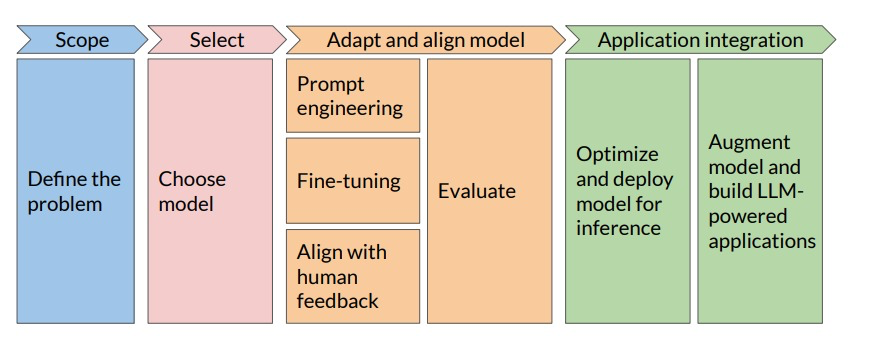

Challenges faced -

>
>
>
>



1. Challenges of Full Fine-Tuning:

Memory Requirements: Storing various parameters, including model weights, optimizer states, gradients, forward activations, and temporary memory, poses challenges on consumer hardware.
Catastrophic Forgetting: Updating all model weights during supervised learning may lead to forgetting tasks the model was initially proficient in.
2. Parameter-Efficient Fine-Tuning (PEFT):

Selective PEFT Methods: Fine-tune only a subset of the original LLM parameters, with various approaches to identify which parameters to update (not extensively discussed in this course).
Reparameterization Methods (e.g., LoRA): Reduce the number of trainable parameters by creating new low-rank transformations of the original network weights.
Additive PEFT Methods:
Adapter Methods: Introduce new trainable layers within the model architecture, typically inside the encoder or decoder components.
Soft Prompt Methods (e.g., Prompt Tuning): Keep the model architecture fixed and manipulate the input to achieve better performance, often by adding trainable parameters to prompt embeddings.
3. Advantages of PEFT:

Memory Efficiency: PEFT, with frozen or slightly modified LLM weights, significantly reduces memory requirements, allowing for training on a single GPU.
Adaptability to Multiple Tasks: PEFT enables efficient adaptation of the original LLM to various tasks without creating new versions of the model for each task.
4. Trade-offs in PEFT Methods:

Parameter Efficiency vs. Compute Efficiency: Selective methods may exhibit mixed performance with trade-offs between parameter efficiency and compute efficiency.
Inference Costs: Different PEFT methods have varying implications for model quality, inference costs, and training speed.



References -
https://www.deeplearning.ai/
https://github.com/Ryota-Kawamura/Generative-AI-with-LLMs/tree/5563fae447eb09be0cd1b8970fa8b07fa3b88042
